Install NumPyro by running:
`$ pip install --upgrade numpyro`

In [1]:
from functools import partial

# Import regular numpy in additional to JAX's
import numpy
import scipy.stats

import matplotlib.pyplot as plt
%matplotlib inline

%run helpers.ipynb

In [2]:
# Compute on a CPU using 2 cores
numpyro.set_platform("cpu")
numpyro.set_host_device_count(2)

# Make plots larger by default
plt.rc("figure", dpi=100)

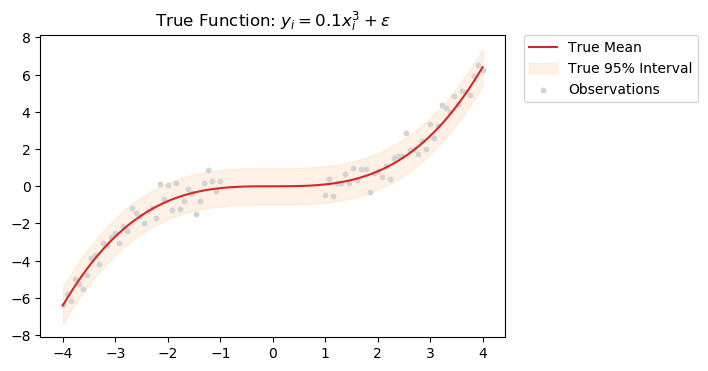

In [3]:
# Define the true function and generate observations
func = lambda x: scipy.stats.norm(loc=0.1 * x ** 3, scale=0.5)
func.latex = r"$y_i = 0.1x_i^3 + \varepsilon$"

data_points = [
    {"n_points": 40, "xlim": [-4, -1]},
    {"n_points": 40, "xlim": [1, 4]},
]
df = generate_data(func, points=data_points, seed=4)

# Plot the data
plot_true_function(func, df, title=f"True Function: {func.latex}")

In [4]:
# Observations
X = df[["x"]].values
Y = df[["y"]].values
X_test = numpy.linspace(X.min(), X.max(), num=1000)[:, np.newaxis]

# Number of hidden layers
hidden = 1
# Width of hidden layers
width = 10
# Standard deviation of the prior
sigma = 2.0
# Standard deviation of the likelihood
noise = 0.5

# Instantiate the model with prior standard deviation and likelihood noise
model = partial(feedforward, X=X, Y=Y, width=width, hidden=hidden, sigma=sigma, noise=noise)

# No-U-Turn Sampling

In [5]:
%%time
# NUTS parameters
num_chains = 2
num_samples = 2000
num_warmup = 2000

# Run the No-U-Turn sampler. Note: sampling more than one chain in parallel doesn't show a progress bar
mcmc = sample(model, num_samples, num_warmup, num_chains, seed=0, summary=True)


                mean       std    median      5.0%     95.0%     n_eff     r_hat
   b0[0,0]      0.07      2.30      0.06     -3.53      3.81    785.15      1.00
   b0[0,1]     -0.05      2.27     -0.02     -3.62      3.66    682.22      1.00
   b0[0,2]      0.01      2.26     -0.02     -3.62      3.67    700.38      1.00
   b0[0,3]      0.06      2.25      0.08     -3.54      3.70    702.30      1.00
   b0[0,4]      0.03      2.30      0.05     -3.59      3.83    772.64      1.00
   b0[0,5]      0.02      2.28      0.06     -3.69      3.70    772.97      1.00
   b0[0,6]     -0.07      2.22     -0.10     -3.71      3.49    708.42      1.00
   b0[0,7]      0.02      2.29      0.08     -3.54      3.78    675.84      1.01
   b0[0,8]     -0.13      2.25     -0.11     -3.77      3.56    729.95      1.01
   b0[0,9]     -0.16      2.23     -0.13     -3.76      3.44    728.31      1.01
        b1     -0.01      1.45     -0.02     -2.51      2.23   2788.87      1.00
   w0[0,0]     -0.12      1

In [ ]:
# Generate the posterior predictive and plot the results
posterior_predictive = simulate_posterior_predictive(model, mcmc, X_test, seed=1)
plot_posterior_predictive(
    X_test,
    posterior_predictive,
    func=func,
    df=df,
    title=f"NUTS, Weight Uncertainty {sigma}, Noise {noise},\n" f"{width} Nodes in {hidden} Hidden Layer",
)

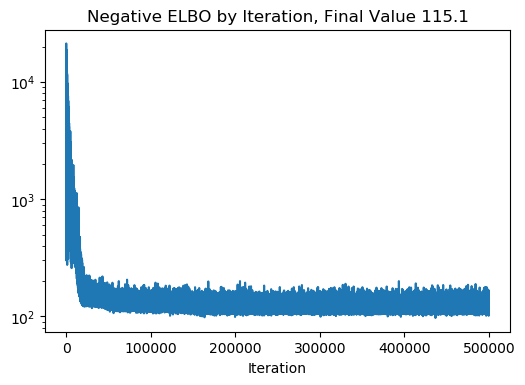

In [7]:
# Approximate the posterior using Automatic Differentiation Variational Inference
vi = advi(model, num_iter=500_000, learning_rate=0.001, seed=0)
vi.plot_loss()

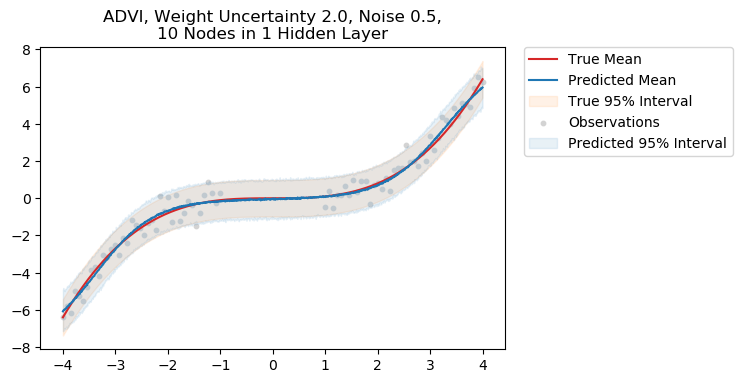

In [8]:
# Generate the posterior predictive and plot the results
posterior_predictive = simulate_posterior_predictive(model, vi, X_test, n_samples=1000, seed=1)
plot_posterior_predictive(
    X_test,
    posterior_predictive,
    func=func,
    df=df,
    title=f"ADVI, Weight Uncertainty {sigma}, Noise {noise},\n" f"{width} Nodes in {hidden} Hidden Layer",
)